In [137]:
from PIL import Image, ImageDraw, ImageOps, ImageEnhance, ImageFilter, ImageFont
import numpy as np
import cv2
import os
import io

# Новое решение

In [122]:
def get_vertices(gs):
    vertices = np.zeros((256, 12, 3))
    gs = np.array(gs).flatten()
    for t in range(256):
        index = 0
        for i, j in ((0, 1), (1, 2), (0, 2)):
            for i_limit in (0, 1):
                for j_limit in (0, 1):
                    A = np.array([[*gs], 
                                  [*np.eye(3)[i]], 
                                  [*np.eye(3)[j]]])
                    b = np.array([t / 255, i_limit, j_limit])
                    try:
                        vertices[t, index] = np.linalg.solve(A, b)
                    except np.linalg.LinAlgError:
                        vertices[t, index] = np.array([2, 2, 2])
                        
                    index += 1
    return vertices

In [227]:
def hide(image, 
         target=0.5,
         grayscale=[0.2126, 0.7152, 0.0722]):
    # Масштабирование цветов в диапазон [0, 1]
    image_np = np.array(image)[..., :3] / 255
    # Размеры исходного изображения
    h, w, _ = image_np.shape
    # Преобразование в вектор-строку
    gs = np.reshape(grayscale, (1, 3))
    gs = gs / gs.sum()
    # Формулирование цели для алгоритма
    if isinstance(target, float):
        t = target
        t_index = np.full((h, w), round(t * 255))
    else:
        target_np = np.array(target)[..., :3] / 255
        t = target_np.reshape((h, w, 1, 3)) @ gs.T
        t_index = np.round(t.reshape(h, w) * 255).astype(int)
    # Массив из цветов исходного изображения
    colors = image_np.reshape((h, w, 1, 3))
    # Идеальные цвета для цели (пересечение Плоскости и нормали к ней)
    ci = gs * (t - colors @ gs.T) / (gs @ gs.T) + colors
    # Точки, полученные пересечением всех пар границ с Плоскостью
    vertices = get_vertices(gs)[t_index]
    # Индексы внутри RGB для рассчетов
    ks = (np.eye(6, k=-1) + np.eye(6))[..., ::2]
    # Границы (правая часть в уравнениях их плоскостей)
    alphas = np.reshape([0, 1] * 3, (6, 1))
    # Направляющие вектора от ci к пересечениям Плоскости и границ для RGB
    ms = np.cross(gs.flatten(), np.cross(gs.flatten(), ks))
    # Точки, лежащие на пересечениях Плоскости и границ для RGB
    _ksms = (ks[..., None, :] @ ms[..., None]).reshape(6, 1)
    modas = ms * (alphas - ks @ ci.reshape((h, w, 3, 1))) / _ksms + ci
    # Все варианты расположения наилучшей точки
    options = np.concatenate([ci, vertices, modas], axis=-2)
    # Отсеивание точек за пределами 0 и 255
    _casted = np.round(options * 255)
    mask = np.any(_casted < 0, axis=-1) | np.any(_casted > 255, axis=-1)
    options[mask] = np.array([100] * 3)
    # Выбор лучшего варианта
    _ds = np.sum((options - ci) ** 2, axis=-1)
    best_indices = (np.arange(h)[:, None, None], 
                    np.arange(w)[None, :, None], 
                    np.argmin(_ds, axis=-1)[..., None], 
                    np.arange(3))
    nc = options[best_indices]
    # Итоговый результат
    return Image.fromarray(np.round(nc * 255).astype('uint8'))

# Открытие изображений

In [39]:
def prepare_input(img1_path, img2_path):
    img1 = Image.open(img1_path)
    img2 = Image.open(img2_path)
    
    img1_ratio = img1.size[0] / img1.size[1]
    img2_ratio = img2.size[0] / img2.size[1]
    
    if img2_ratio > img1_ratio:
        img2 = img2.resize((int(img1.size[1] * img2_ratio),
                            img1.size[1]))
        crop_x = round(img2.size[0] / 2 - img1.size[0] / 2)
        img2 = img2.crop((crop_x, 
                          0, 
                          crop_x + img1.size[0], 
                          img2.size[1]))
    else:
        img2 = img2.resize((img1.size[0], 
                            int(img1.size[0] / img2_ratio)))
        crop_y = round(img2.size[1] / 2 - img1.size[1] / 2)
        img2 = img2.crop((0,
                          crop_y, 
                          img2.size[0], 
                          crop_y + img1.size[1]))
        
    return img1, img2

# Использование

In [111]:
# source = Image.open('input/rainbow.png')
# source = Image.open('input/frog.png')
source, secret = prepare_input(
    'input/frog.png',
    'input/food.jpg',
    # 'input/moscow.jpg', 
    # 'input/field.jpg',
    # 'input/rainbow.png',
)

In [208]:
gs = [0.2126, 0.7152, 0.0722]
# gs = [0.299, 0.587, 0.114]

In [121]:
# secret = Image.fromarray(np.random.randint(0, 255, (*source.size[::-1], 3), dtype='uint8'))

In [145]:
np.array(source).mean(axis=(0, 1)) @ np.array(gs) / 255

0.2978583780527986

CPU times: user 2.93 s, sys: 1.27 s, total: 4.19 s
Wall time: 4.69 s


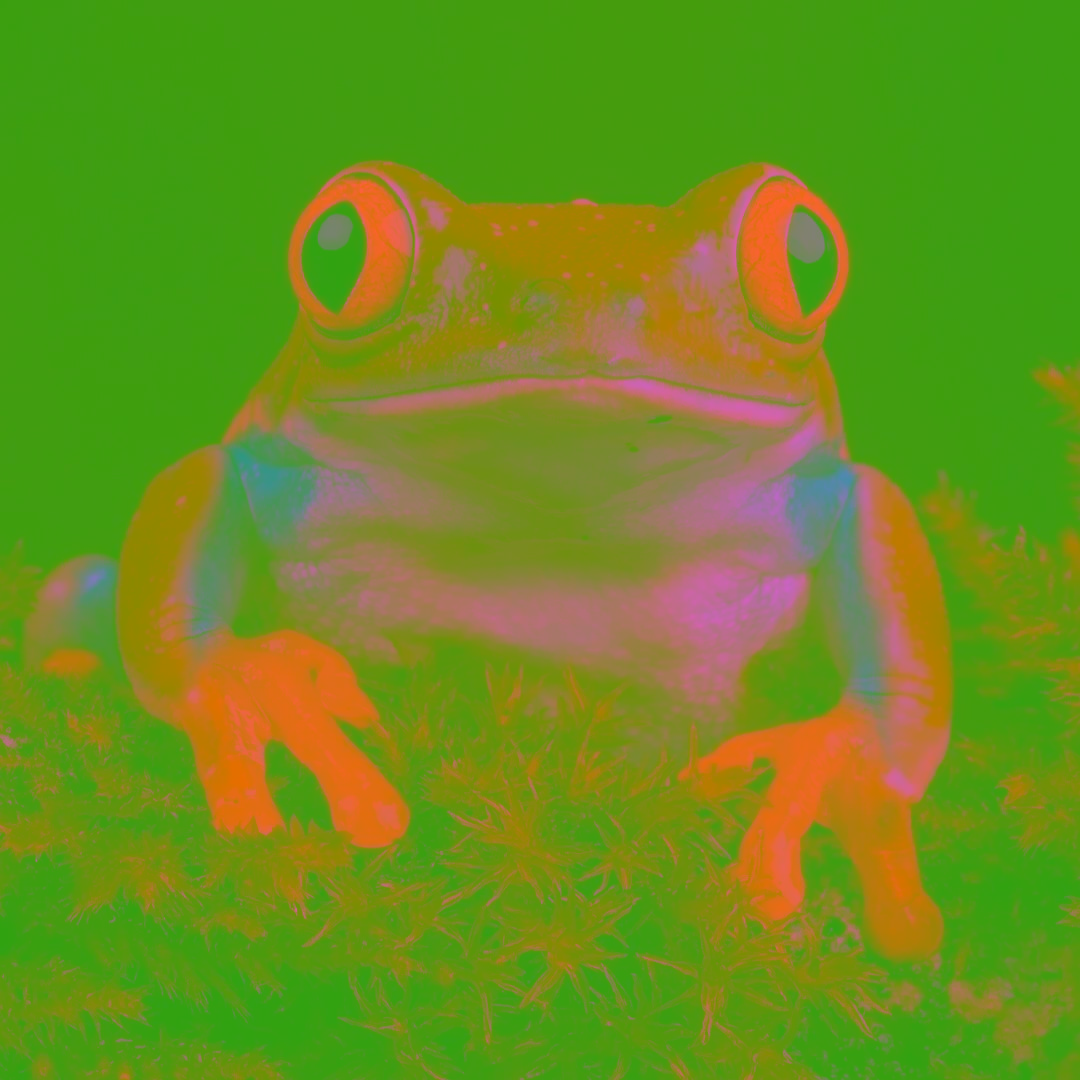

In [229]:
%%time

hide(source, 0.5)
# hide(source, secret)
# hide(secret, source)

In [217]:
%%time

image = source
target = 0.2
grayscale = [0.2126, 0.7152, 0.0722]


# Масштабирование цветов в диапазон [0, 1]
image_np = np.array(image)[..., :3] / 255
# Размеры исходного изображения
h, w, _ = image_np.shape
# Преобразование в вектор-строку
gs = np.reshape(grayscale, (1, 3))
gs = gs / gs.sum()
# Формулирование цели для алгоритма
if isinstance(target, float):
    t = target
    t_index = np.full((h, w), round(t * 255))
else:
    target_np = np.array(target)[..., :3] / 255
    t = target_np.reshape((h, w, 1, 3)) @ gs.T
    t_index = np.round(t.reshape(h, w) * 255).astype(int)
# Массив из цветов исходного изображения
colors = image_np.reshape((h, w, 1, 3))
# Идеальные цвета для цели (пересечение Плоскости и нормали к ней)
ci = gs * (t - colors @ gs.T) / (gs @ gs.T) + colors
# Точки, полученные пересечением всех пар границ с Плоскостью
vertices = get_vertices(gs)[t_index]
# Индексы внутри RGB для рассчетов
ks = (np.eye(6, k=-1) + np.eye(6))[..., ::2]
# Границы (правая часть в уравнениях их плоскостей)
alphas = np.reshape([0, 1] * 3, (6, 1))
# Направляющие вектора от ci к пересечениям Плоскости и границ для RGB
ms = np.cross(gs.flatten(), np.cross(gs.flatten(), ks))
# Точки, лежащие на пересечениях Плоскости и границ для RGB
_ksms = (ks[..., None, :] @ ms[..., None]).reshape(6, 1)
modas = ms * (alphas - ks @ ci.reshape((h, w, 3, 1))) / _ksms + ci
# Все варианты расположения наилучшей точки
options = np.concatenate([ci, vertices, modas], axis=-2)
all_options = options.copy()
# Выбор лучшего варианта
mask = np.any(options < 0, axis=-1) | np.any(options > 1, axis=-1)
options[mask] = np.array([3, 3, 3])
_ds = np.sum((options - ci) ** 2, axis=-1)
# _ds = np.sum((options - colors) ** 2, axis=-1)
best_indices = (np.arange(h)[:, None, None], 
                np.arange(w)[None, :, None], 
                np.argmin(_ds, axis=-1)[..., None], 
                np.arange(3))
nc = options[best_indices]

CPU times: user 3.21 s, sys: 1.81 s, total: 5.03 s
Wall time: 7.37 s


In [222]:
np.round(all_options[i0, j0], 5)

array([[ 4.561200e-01,  1.502000e-01, -6.085000e-02],
       [ 0.000000e+00,  0.000000e+00,  2.770080e+00],
       [ 0.000000e+00,  1.000000e+00, -7.135730e+00],
       [ 1.000000e+00,  0.000000e+00, -1.745200e-01],
       [ 1.000000e+00,  1.000000e+00, -1.008033e+01],
       [ 9.407300e-01,  0.000000e+00,  0.000000e+00],
       [ 6.011300e-01,  0.000000e+00,  1.000000e+00],
       [-2.423330e+00,  1.000000e+00,  0.000000e+00],
       [-2.762940e+00,  1.000000e+00,  1.000000e+00],
       [ 0.000000e+00,  2.796400e-01,  0.000000e+00],
       [ 0.000000e+00,  1.786900e-01,  1.000000e+00],
       [ 1.000000e+00, -1.762000e-02,  0.000000e+00],
       [ 1.000000e+00, -1.185700e-01,  1.000000e+00],
       [ 0.000000e+00,  2.844200e-01, -4.730000e-02],
       [ 1.000000e+00, -9.840000e-03, -7.700000e-02],
       [ 9.091500e-01,  0.000000e+00,  9.300000e-02],
       [-2.107050e+00,  1.000000e+00, -9.313100e-01],
       [ 4.544500e-01,  1.445500e-01, -0.000000e+00],
       [ 4.268700e-01,  5.18

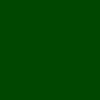

In [211]:
Image.fromarray(np.array(hided)[550, 158][None, None, :]).resize((100, 100))

In [210]:
source_np = np.array(source)
result_np = np.array(hided)

i0, j0 = 550, 158
i1, j1 = 550, 159

print(source_np[i0, j0] / 255, '->', source_np[i1, j1] / 255)
print(result_np[i0, j0] / 255, '->', result_np[i1, j1] / 255)

[0.63529412 0.75294118 0.        ] -> [0.63921569 0.75686275 0.        ]
[0.         0.27843137 0.        ] -> [0.45882353 0.14509804 0.        ]


In [ ]:
result_np[]

In [209]:
print(result_np[i0, j0] @ np.array(gs) / 255)
print(result_np[i1, j1] @ np.array(gs) / 255)

0.1991341176470588
0.20132000000000003


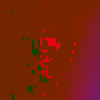

In [196]:
Image.fromarray(np.array(hided)[525:575, 140:190, :]).resize((100, 100))

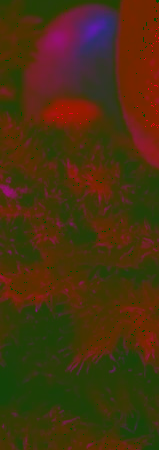

In [176]:
hided.crop((0, 550, 159, 1000))

In [136]:
%%time

frames = []
for i in range(256):
    img = hide(source.resize((200, 200)), i / 255)
    frames.append(img)
    img.save(f'output/frame_{i:03}.png')
    print(f'\r{round(i/255*100, 2)}%', end='')
print()

100.0%
CPU times: user 1min 10s, sys: 7.54 s, total: 1min 17s
Wall time: 1min 41s


In [142]:
%%time

imgs = []
n = 50
img = source.resize((200, 200))

for i in range(n):
    imgs.append(hide(img.filter(ImageFilter.GaussianBlur(i / (n-1) * 100)), 
                     img, ))
    print(f'\r{round(i/(n-1)*100, 2)}%', end='')
print()
imgs[0].save(f'output/blur.gif', 
             save_all=True, 
             append_images=imgs[1:], 
             duration=100)

100.0%
CPU times: user 12.1 s, sys: 1.24 s, total: 13.3 s
Wall time: 14.2 s


In [139]:
frames[0].save(f'output/test.gif', 
               save_all=True, 
               append_images=frames[1:], 
               duration=20)

In [88]:
# source = source.convert('RGBA')
# draw = ImageDraw.Draw(source)
# font = ImageFont.truetype('Arial.ttf', 100)
# W, H = source.size
# message='Hello world'
# _, _, w, h = draw.textbbox((0, 0), message, font=font)
# draw.text(((W-w)/2, (H-h)/2), message, font=font, fill=(255, 0, 255, 50))
# source

CPU times: user 3.76 s, sys: 1.31 s, total: 5.07 s
Wall time: 6.72 s


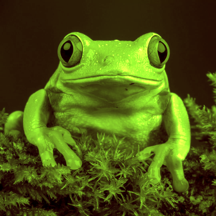

In [151]:
%%time

img = hide(
    source.filter(ImageFilter.GaussianBlur(1000)), 
    source, 
    gs
)
img.resize(np.round(np.array(img.size) * 0.2).astype(int))

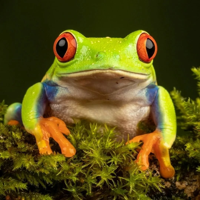

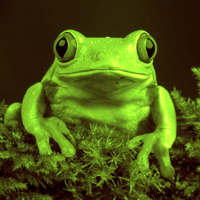

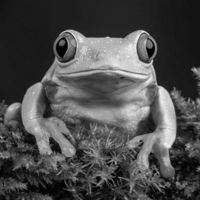

In [152]:
display(source.resize((200, 200)))
display(img.resize((200, 200)))
display(img.convert('L').resize((200, 200)))